In [22]:
# Import Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

In [23]:
# Import Production Data (and State Index)
# Production Data Source
# https://www.kaggle.com/datasets/kevinmorgado/us-energy-generation-2001-2022?select=organised_Gen.csv

# Load the State Index CSV file
state_df = pd.read_csv("Resources/states.csv", usecols = ['State', 'Code'])

# Load the Production CSV file and exclude first column
col_list = ['YEAR', 'MONTH', 'STATE', 'TYPE OF PRODUCER', 'ENERGY SOURCE', 'GENERATION (Megawatthours)']
prod_df = pd.read_csv("Resources/organised_Gen.csv", usecols = col_list)

# Assign title case to column names and rename 'State'
col_list_cased = [col.title() for col in col_list]
prod_df.columns = col_list_cased

# Filter for years 2002 - 2021 to match investment data set
prod_df = prod_df.loc[(prod_df['Year'] > 2001) & (prod_df['Year'] < 2022) & (prod_df['State'] != 'US-TOTAL') & (prod_df['Type Of Producer'] == "Total Electric Power Industry")]

# Filter for common energy types across both data sets
prod_source_list = ['Geothermal', 'Hydroelectric Conventional', 'Other Biomass', 'Solar Thermal and Photovoltaic', 'Wind']
prod_df = prod_df.loc[prod_df['Energy Source'].isin(prod_source_list)]

# Rename energy sources to common convention
prod_df = prod_df.replace(['Hydroelectric Conventional', 'Other Biomass', 'Solar Thermal and Photovoltaic'], 
                          ['Hydroelectric', 'Biomass', 'Solar'])

# Display sample data
prod_df.head()

,Year,Month,State,Type Of Producer,Energy Source,Generation (Megawatthours)
20215,2002,1,AK,Total Electric Power Industry,Hydroelectric,118944.0
20217,2002,1,AK,Total Electric Power Industry,Biomass,999.0
20242,2002,1,AL,Total Electric Power Industry,Hydroelectric,947959.0
20244,2002,1,AL,Total Electric Power Industry,Biomass,1622.0
20273,2002,1,AR,Total Electric Power Industry,Hydroelectric,230870.0


In [24]:
# Import Investment Data
# Investment Data Source
# https://www.wctsservices.usda.gov/Energy/Downloads

# Load the Investment Excel file, "Detailed" Sheet
inv_df = pd.read_excel("Resources/EnergyInvestments_DataDownloads.xlsx", sheet_name = "Detailed")

# Filter for common energy types across both data sets
inv_source_list = ['Geothermal', 'Hydroelectric', 'Renewable Biomass', 'Solar', 'Wind']
inv_df = inv_df.loc[inv_df['Energy Type'].isin(inv_source_list)]

# Rename energy sources to common convention
inv_df = inv_df.replace('Renewable Biomass', 'Biomass')

# Join with State Index data to get State Abbreviation column
inv_df = pd.merge(inv_df, state_df, on = "State")

# Rename columns
inv_df.rename(columns={"State": "State Name", "Code": "State", "Energy Type": "Energy Source", "Program_Name": "Program Name"}, inplace = True)

# Display sample data
inv_df.head()

,State Name,County,Congressional District,Zip Code,Energy Source,Agency,Year,Program Name,Total Number of Investments,Total Amount of Assistance,Description,State
0,Alabama,Baldwin,AL-01,36507,Biomass,FSA,2010,BCAP Matching Payments (NOFA),2,40736.0,NaN,AL
1,Alabama,Baldwin,AL-01,36551,Biomass,FSA,2010,BCAP Matching Payments (NOFA),1,16509.0,NaN,AL
2,Alabama,Baldwin,AL-01,36567,Biomass,FSA,2010,BCAP Matching Payments (NOFA),1,639.0,NaN,AL
3,Alabama,Baldwin,AL-01,36580,Biomass,FSA,2010,BCAP Matching Payments (NOFA),1,16334.0,NaN,AL
4,Alabama,Baldwin,AL-01,36580,Biomass,RBS,2021,Rural Energy for America Program (REAP),1,7000000.0,Landfill Gas,AL


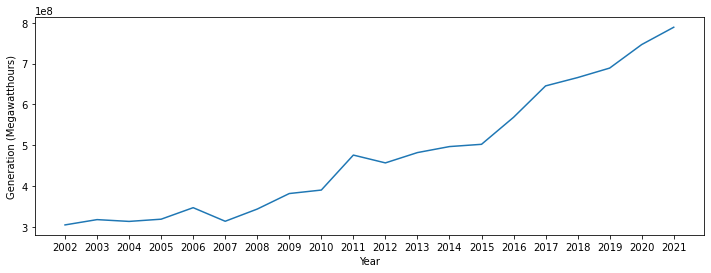

In [25]:

## Look at the trend of total production ('Generation (Megawatthours)') from 2002 - 2021 (all states combined)
# Groupby 'Year'
prod_df_year = prod_df.groupby(["Year"])

# x-axis
x_axis = prod_df_year['Year'].first()

# y-axis
y_axis = prod_df_year['Generation (Megawatthours)'].sum()

# Line plot
plt.figure(figsize = (12, 4))
plt.plot(x_axis, y_axis)
plt.xlabel("Year")
plt.xticks(np.arange(x_axis.min(), x_axis.max() + 1, 1.0))
plt.ylabel("Generation (Megawatthours)")
plt.show()

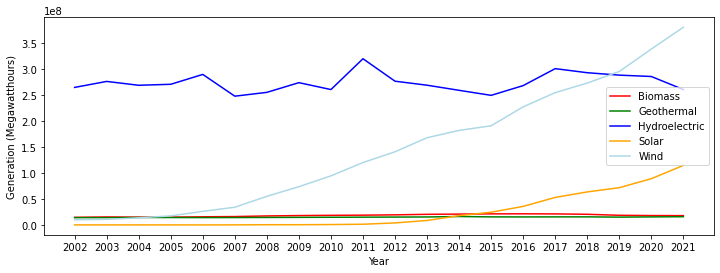

In [26]:

## Look at the trend of total production ('Generation (Megawatthours)') from 2002 - 2021 per Energy Source (all states combined)
# Energy Source List
source_list = ['Biomass', 'Geothermal', 'Hydroelectric', 'Solar', 'Wind']

# Color List
colors = ['red', 'green', 'blue', 'orange', 'lightblue']

# y-axis - Filter for 'Energy Source'
prod_df_bio = prod_df.loc[prod_df['Energy Source'] == source_list[0]].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_geo = prod_df.loc[prod_df['Energy Source'] == source_list[1]].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_hyd = prod_df.loc[prod_df['Energy Source'] == source_list[2]].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_sol = prod_df.loc[prod_df['Energy Source'] == source_list[3]].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_wnd = prod_df.loc[prod_df['Energy Source'] == source_list[4]].groupby(["Year"])['Generation (Megawatthours)'].sum()

# Line plot
plt.figure(figsize = (12, 4))
bio, = plt.plot(x_axis, prod_df_bio, color = colors[0], label = source_list[0])
geo, = plt.plot(x_axis, prod_df_geo, color = colors[1], label = source_list[1])
hyd, = plt.plot(x_axis, prod_df_hyd, color = colors[2], label = source_list[2])
sol, = plt.plot(x_axis, prod_df_sol, color = colors[3], label = source_list[3])
wnd, = plt.plot(x_axis, prod_df_wnd, color = colors[4], label = source_list[4])
plt.xlabel("Year")
plt.xticks(np.arange(x_axis.min(), x_axis.max() + 1, 1.0))
plt.ylabel("Generation (Megawatthours)")
plt.legend(handles = [bio, geo, hyd, sol, wnd], loc = "best")
plt.show()

In [27]:
## Look at the trend of total production ('Generation (Megawatthours)') from 2002 - 2021 per Energy Source (all states combined)

# Filter for 2002, 2021 and ENergy Source
prod_df_bio_02 = prod_df.loc[(prod_df['Energy Source'] == source_list[0]) & (prod_df['Year'] == 2002)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_bio_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[0]) & (prod_df['Year'] == 2021)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_geo_02 = prod_df.loc[(prod_df['Energy Source'] == source_list[1]) & (prod_df['Year'] == 2002)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_geo_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[1]) & (prod_df['Year'] == 2021)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_hyd_02 = prod_df.loc[(prod_df['Energy Source'] == source_list[2]) & (prod_df['Year'] == 2002)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_hyd_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[2]) & (prod_df['Year'] == 2021)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_sol_02 = prod_df.loc[(prod_df['Energy Source'] == source_list[3]) & (prod_df['Year'] == 2002)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_sol_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[3]) & (prod_df['Year'] == 2021)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_wnd_02 = prod_df.loc[(prod_df['Energy Source'] == source_list[4]) & (prod_df['Year'] == 2002)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_wnd_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[4]) & (prod_df['Year'] == 2021)].groupby(["Year"])['Generation (Megawatthours)'].sum()

# Build summary table showing descending movement per energy source
summary = pd.DataFrame({'Energy Source': source_list,
                       'Movement 2021 vs 2002':[(list(prod_df_bio_21)[0] / list(prod_df_bio_02)[0]) - 1,
                                                (list(prod_df_geo_21)[0] / list(prod_df_geo_02)[0]) - 1,
                                                (list(prod_df_hyd_21)[0] / list(prod_df_hyd_02)[0]) - 1,
                                                (list(prod_df_sol_21)[0] / list(prod_df_sol_02)[0]) - 1,
                                                (list(prod_df_wnd_21)[0] / list(prod_df_wnd_02)[0]) - 1]})
summary = summary.sort_values(by=['Movement 2021 vs 2002'], ascending = False)
summary['Movement 2021 vs 2002'] = summary['Movement 2021 vs 2002'].map("{:,.0%}".format)
summary


,Energy Source,Movement 2021 vs 2002
3,Solar,"20,569%"
4,Wind,"3,568%"
0,Biomass,22%
1,Geothermal,12%
2,Hydroelectric,-2%


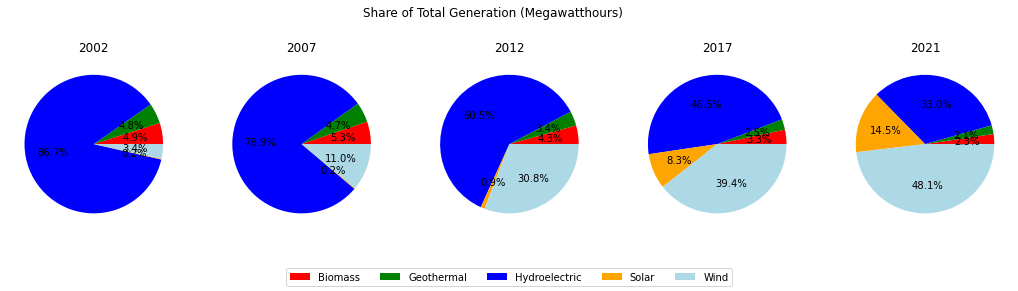

In [28]:
## Look at the trend of share total production ('Generation (Megawatthours)') every five years from 2002 - 2021 per Energy Source (all states combined)

# Filter for every five years - 2002, 2007, 2012, 2017, 2021
prod_df_02 = prod_df.loc[prod_df['Year'] == 2002].groupby(['Energy Source'])['Generation (Megawatthours)'].sum()
prod_df_07 = prod_df.loc[prod_df['Year'] == 2007].groupby(['Energy Source'])['Generation (Megawatthours)'].sum()
prod_df_12 = prod_df.loc[prod_df['Year'] == 2012].groupby(['Energy Source'])['Generation (Megawatthours)'].sum()
prod_df_17 = prod_df.loc[prod_df['Year'] == 2017].groupby(['Energy Source'])['Generation (Megawatthours)'].sum()
prod_df_21 = prod_df.loc[prod_df['Year'] == 2021].groupby(['Energy Source'])['Generation (Megawatthours)'].sum()

# y labels
label_source = prod_df.groupby(['Energy Source'])['Energy Source'].first()

# Build pie chart subplots
fig, axs = plt.subplots(1, 5, figsize=(18, 4), sharey=True)
axs[0].pie(list(prod_df_02), colors = colors, autopct="%1.1f%%")
axs[0].title.set_text('2002')
axs[1].pie(list(prod_df_07), colors = colors, autopct="%1.1f%%")
axs[1].title.set_text('2007')
axs[2].pie(list(prod_df_12), colors = colors, autopct="%1.1f%%")
axs[2].title.set_text('2012')
axs[3].pie(list(prod_df_17), colors = colors, autopct="%1.1f%%")
axs[3].title.set_text('2017')
axs[4].pie(list(prod_df_21), colors = colors, autopct="%1.1f%%")
axs[4].title.set_text('2021')
fig.suptitle('Share of Total Generation (Megawatthours)')
fig.legend(list(label_source), loc='lower center', ncol=len(list(label_source)), bbox_transform=fig.transFigure)


In [29]:
## Look at share of total production ('Generation (Megawatthours)') per Energy Source per State in 2021

# Filter by 2021 and group by State for ALL Energy Sources combined
prod_df_state = prod_df.loc[prod_df['Year'] == 2021].groupby(['State'])['Generation (Megawatthours)'].sum()

# Filter by 2021 and group by State for each Energy Source
prod_df_bio_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[0]) & (prod_df['Year'] == 2021)].groupby(["State"])['Generation (Megawatthours)'].sum()
prod_df_geo_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[1]) & (prod_df['Year'] == 2021)].groupby(["State"])['Generation (Megawatthours)'].sum()
prod_df_hyd_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[2]) & (prod_df['Year'] == 2021)].groupby(["State"])['Generation (Megawatthours)'].sum()
prod_df_sol_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[3]) & (prod_df['Year'] == 2021)].groupby(["State"])['Generation (Megawatthours)'].sum()
prod_df_wnd_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[4]) & (prod_df['Year'] == 2021)].groupby(["State"])['Generation (Megawatthours)'].sum()

# Merge datasets to show evergy sources side-by-side
state_pct = pd.merge(prod_df_state, prod_df_bio_21, how = 'left', on = "State")
state_pct.rename(columns={"Generation (Megawatthours)_x": "Total", "Generation (Megawatthours)_y": source_list[0]}, inplace = True)
state_pct = pd.merge(state_pct, prod_df_geo_21, how = 'left', on = "State")
state_pct.rename(columns={"Generation (Megawatthours)": source_list[1]}, inplace = True)
state_pct = pd.merge(state_pct, prod_df_hyd_21, how = 'left', on = "State")
state_pct.rename(columns={"Generation (Megawatthours)": source_list[2]}, inplace = True)
state_pct = pd.merge(state_pct, prod_df_sol_21, how = 'left', on = "State")
state_pct.rename(columns={"Generation (Megawatthours)": source_list[3]}, inplace = True)
state_pct = pd.merge(state_pct, prod_df_wnd_21, how = 'left', on = "State")
state_pct.rename(columns={"Generation (Megawatthours)": source_list[4]}, inplace = True)
state_pct = state_pct.fillna(0)

# Create new columns for % share of total production
state_pct['Biomass %'] = (state_pct[source_list[0]] / state_pct['Total'])
state_pct['Geothermal %'] = (state_pct[source_list[1]] / state_pct['Total'])
state_pct['Hydroelectric %'] = (state_pct[source_list[2]] / state_pct['Total'])
state_pct['Solar %'] = (state_pct[source_list[3]] / state_pct['Total'])
state_pct['Wind %'] = (state_pct[source_list[4]] / state_pct['Total'])
state_pct = state_pct.iloc[:, 6:11]
state_pct

,Biomass %,Geothermal %,Hydroelectric %,Solar %,Wind %
State,,,,,
AK,0.021093,0.000000,0.908719,0.000000,0.070188
AL,0.002903,0.000000,0.959141,0.037957,0.000000
AR,0.019072,0.000000,0.886010,0.094918,0.000000
AZ,0.001543,0.000000,0.411838,0.473327,0.113292
CA,0.032963,0.145859,0.185523,0.436547,0.199108
CO,0.004324,0.000000,0.089103,0.094817,0.811755
CT,0.431041,0.000000,0.294164,0.263201,0.011594
DC,0.681995,0.000000,0.000000,0.318005,0.000000
DE,0.517045,0.000000,0.000000,0.447665,0.035291


In [30]:
## Look at Top 5 states per Energy Source in 2021

# Sort state_pct table by each Energy Source (descending)
bio_pct = state_pct.sort_values(by=['Biomass %'], ascending = False)
bio = list(bio_pct.iloc[0:5, 0].index)
geo_pct = state_pct.sort_values(by=['Geothermal %'], ascending = False)
geo = list(geo_pct.iloc[0:5, 1].index)
hyd_pct = state_pct.sort_values(by=['Hydroelectric %'], ascending = False)
hyd = list(hyd_pct.iloc[0:5, 2].index)
sol_pct = state_pct.sort_values(by=['Solar %'], ascending = False)
sol = list(sol_pct.iloc[0:5, 3].index)
wnd_pct = state_pct.sort_values(by=['Wind %'], ascending = False)
wnd = list(wnd_pct.iloc[0:5, 4].index)

# Create summary dataframe to show the top 5 states for each Energy Source
summary = pd.DataFrame({'Rank': np.arange(1, 6, 1),
                        'Biomass %': bio,
                        'Geothermal %': geo,
                        'Hydroelectric %': hyd,
                        'Solar %': sol,
                        'Wind %': wnd})
summary

,Rank,Biomass %,Geothermal %,Hydroelectric %,Solar %,Wind %
0,1,DC,NV,KY,MS,KS
1,2,DE,CA,TN,FL,IA
2,3,CT,HI,AL,NJ,IL
3,4,NJ,UT,AK,UT,OK
4,5,RI,ID,AR,VA,WY


In [31]:
# Import Census Data
# Census Data Sources

# https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html
# https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-total.html
# https://www.census.gov/programs-surveys/popest/technical-documentation/research/evaluation-estimates.2010.html#list-tab-Y660N3MTL49GQLLYDJ

years = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
        2017, 2018, 2019, 2020, 2021]

census_df = pd.DataFrame(columns=['State', 'Population', 'Year'])

state = []
population = []
iterationyear = []

for year in years:
        
    if year < 2011:
        
        popappend = "POPESTIMATE" + str(year)
        
        pop_df = pd.read_csv("Resources/co-est2010-alldata.csv", encoding='ISO-8859-1')
        pop_df = pop_df[[popappend, 'STNAME', 'CTYNAME']]
        pop_df = pop_df.rename(columns={popappend: "Population", "STNAME": "State"})
       
        # This specific dataset is broken down by city pop as well, but the full state pop
        # is held in a 'city' that is the state name, so dropping any rows where
        # the state name is not equal to the city name.
        pop_df = pop_df[pop_df.State == pop_df.CTYNAME]
       
        for ind in pop_df.index:
            state.append(pop_df['State'][ind])
            population.append(pop_df['Population'][ind])
            iterationyear.append(year)
            
    if (year > 2010 and year < 2020):
    
        popappend = "POPESTIMATE" + str(year)
        pop_df = pd.read_csv("Resources/nst-est2019-alldata.csv", encoding='ISO-8859-1')
        pop_df = pop_df[[popappend, 'NAME']]
        pop_df = pop_df.rename(columns={popappend: "Population", "NAME": "State"})
        
        for ind in pop_df.index:
            state.append(pop_df['State'][ind])
            population.append(pop_df['Population'][ind])
            iterationyear.append(year)
    
    if year > 2019:
    
        popappend = "POPESTIMATE" + str(year)
        pop_df = pd.read_csv("Resources/NST-EST2021-alldata.csv", encoding='ISO-8859-1')
        pop_df = pop_df[[popappend, 'NAME']]
        pop_df = pop_df.rename(columns={popappend: "Population", "NAME": "State"})
        
        for ind in pop_df.index:
            state.append(pop_df['State'][ind])
            population.append(pop_df['Population'][ind])
            iterationyear.append(year)
        
        
census_df['State'] = state
census_df['Population'] = population
census_df['Year'] = iterationyear
                                     
print(census_df)

cleaned_census_df = census_df.groupby(['State', 'Year']).sum()

print(cleaned_census_df)


              State  Population  Year
0           Alabama     4471462  2002
1            Alaska      641974  2002
2           Arizona     5451472  2002
3          Arkansas     2704471  2002
4        California    34867773  2002
...             ...         ...   ...
1090     Washington     7738692  2021
1091  West Virginia     1782959  2021
1092      Wisconsin     5895908  2021
1093        Wyoming      578803  2021
1094    Puerto Rico     3263584  2021

[1095 rows x 3 columns]
              Population
State   Year            
Alabama 2002     4471462
        2003     4489876
        2004     4510588
        2005     4542912
        2006     4594911
...                  ...
Wyoming 2017      578931
        2018      577601
        2019      578759
        2020      577267
        2021      578803

[1086 rows x 1 columns]


In [81]:
#Get all Energy sources grouped into States instead of county
invest_df = inv_df.drop(columns=['County','Agency','Program Name','Congressional District','Zip Code','Description'])

#Getting all of the data for each year under each state
invest_df.groupby(['State', 'Year', 'Energy Source'], as_index=False).agg('sum')
invest_df


,State Name,Energy Source,Year,Total Number of Investments,Total Amount of Assistance,State
0,Alabama,Biomass,2010,2,40736.00,AL
1,Alabama,Biomass,2010,1,16509.00,AL
2,Alabama,Biomass,2010,1,639.00,AL
3,Alabama,Biomass,2010,1,16334.00,AL
4,Alabama,Biomass,2021,1,7000000.00,AL
...,...,...,...,...,...,...
14348,Wyoming,Wind,2006,1,5014.00,WY
14349,Wyoming,Wind,2007,1,33000.00,WY
14350,Wyoming,Wind,2006,1,14200.00,WY
14351,Wyoming,Wind,2006,1,13666.88,WY


In [82]:
#Aggregating the total amount of investment throughout the entire 2 decades by each State and Energy Source

wind_inv = invest_df.loc[invest_df['Energy Source'] == 'Wind'].groupby(['State'])['Total Amount of Assistance'].sum()
bio_inv = invest_df.loc[invest_df['Energy Source'] == 'Biomass'].groupby(['State'])['Total Amount of Assistance'].sum()
solar_inv = invest_df.loc[invest_df['Energy Source'] == 'Solar'].groupby(['State'])['Total Amount of Assistance'].sum()
geo_inv = invest_df.loc[invest_df['Energy Source'] == 'Geothermal'].groupby(['State'])['Total Amount of Assistance'].sum()
hydro_inv = invest_df.loc[invest_df['Energy Source'] == 'Hydroelectric'].groupby(['State'])['Total Amount of Assistance'].sum()

In [83]:
#Turn the variables into a DataFrame of each Energy Source by State
energy_inv_total = pd.DataFrame({
                                "Wind": wind_inv,
                                "Biomass": bio_inv,
                                "Hydroelectric": hydro_inv,
                                "Solar": solar_inv,
                                "Geothermal": geo_inv})
                                
#Formatting columns for total amount of dollars invested
energy_inv_total['Wind'] = energy_inv_total['Wind']
energy_inv_total['Biomass'] = energy_inv_total['Biomass']
energy_inv_total['Hydroelectric'] = energy_inv_total['Hydroelectric']
energy_inv_total['Solar'] = energy_inv_total['Solar']
energy_inv_total['Geothermal'] = energy_inv_total['Geothermal']

energy_inv_total.reset_index()

,State,Wind,Biomass,Hydroelectric,Solar,Geothermal
0,AK,2.757067e+07,7.344598e+06,53877554.00,5.567280e+06,NaN
1,AL,NaN,3.731169e+07,NaN,2.462549e+06,3875.00
2,AR,1.498100e+04,3.780391e+07,NaN,1.388855e+08,669875.00
3,AZ,4.976262e+04,9.021376e+06,NaN,2.130279e+08,NaN
4,CA,1.689610e+05,2.281292e+08,348750.00,9.157084e+07,NaN
5,CO,2.333880e+05,1.351786e+07,13900954.00,9.305336e+06,184194.00
6,CT,NaN,2.700024e+06,420000.00,2.816940e+06,45374.00
7,DE,NaN,3.920990e+06,NaN,2.711376e+07,NaN
8,FL,NaN,1.519637e+08,NaN,1.102959e+08,NaN
9,GA,NaN,2.137113e+08,NaN,3.139146e+07,25491.00


In [103]:
#Replacing NaN's with 0 within DataFrame
energy_inv_total = energy_inv_total.fillna(0)
energy_inv_total.reset_index()

,State,Wind,Biomass,Hydroelectric,Solar,Geothermal
0,AK,27570670.0,7.344598e+06,53877554.00,5.567280e+06,0.00
1,AL,0.0,3.731169e+07,0.00,2.462549e+06,3875.00
2,AR,14981.0,3.780391e+07,0.00,1.388855e+08,669875.00
3,AZ,49763.0,9.021376e+06,0.00,2.130279e+08,0.00
4,CA,168961.0,2.281292e+08,348750.00,9.157084e+07,0.00
5,CO,233388.0,1.351786e+07,13900954.00,9.305336e+06,184194.00
6,CT,0.0,2.700024e+06,420000.00,2.816940e+06,45374.00
7,DE,0.0,3.920990e+06,0.00,2.711376e+07,0.00
8,FL,0.0,1.519637e+08,0.00,1.102959e+08,0.00
9,GA,0.0,2.137113e+08,0.00,3.139146e+07,25491.00


In [159]:
energy_inv_total['Wind'] = energy_inv_total['Wind'].astype(int)
energy_inv_total['Biomass'] = energy_inv_total['Biomass'].astype(int)
energy_inv_total['Hydroelectric'] = energy_inv_total['Hydroelectric'].astype(int)
energy_inv_total['Solar'] = energy_inv_total['Solar'].astype(int)
energy_inv_total['Geothermal'] = energy_inv_total['Geothermal'].astype(int)
energy_inv_total

,Wind,Biomass,Hydroelectric,Solar,Geothermal
State,,,,,
AK,27570670,7344597,53877554,5567280,0
AL,0,37311692,0,2462549,3875
AR,14981,37803910,0,138885525,669875
AZ,49763,9021376,0,213027922,0
CA,168961,228129156,348750,91570835,0
CO,233388,13517855,13900954,9305336,184194
CT,0,2700023,420000,2816940,45374
DE,0,3920990,0,27113758,0
FL,0,151963727,0,110295906,0


<AxesSubplot:title={'center':'Investment of Energy Source Per State'}, xlabel='State', ylabel='Investment in Dollars (in Hundred Millions)'>

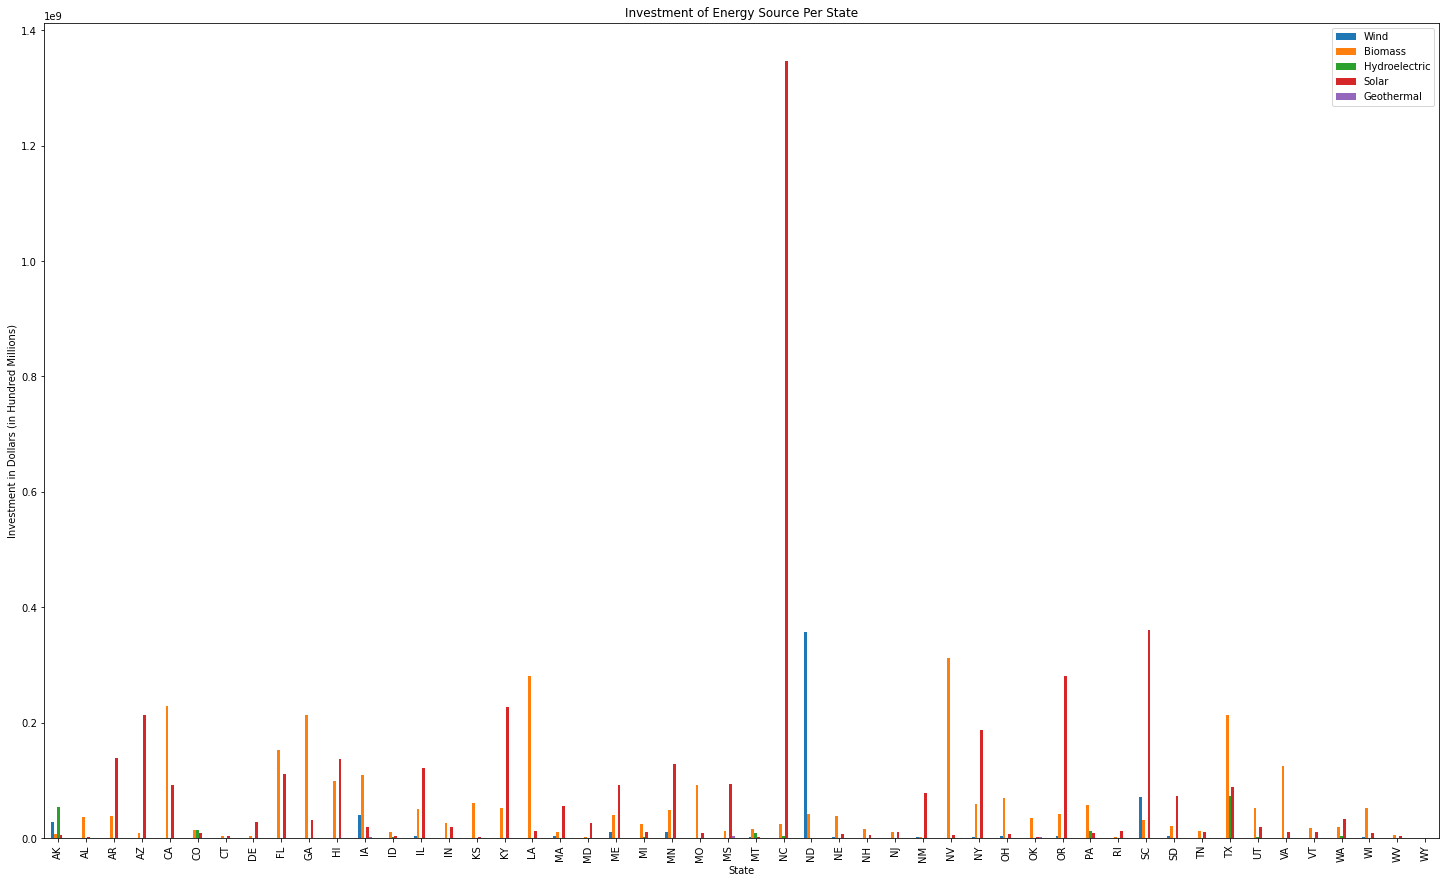

In [160]:
#Create Hbar for each States total Investment for entire 2 decades per Energy Source

energy_inv_total.plot.bar(figsize =(25,15), title= 'Investment of Energy Source Per State',ylabel='Investment in Dollars (in Hundred Millions)')

In [161]:

bio_inv = energy_inv_total.sort_values(by=['Biomass'], ascending = False)
bio = list(bio_inv.iloc[0:5, 0].index)
geo_inv = energy_inv_total.sort_values(by=['Geothermal'], ascending = False)
geo = list(geo_inv.iloc[0:5, 1].index)
hyd_inv = energy_inv_total.sort_values(by=['Hydroelectric'], ascending = False)
hyd = list(hyd_inv.iloc[0:5, 2].index)
sol_inv = energy_inv_total.sort_values(by=['Solar'], ascending = False)
sol = list(sol_inv.iloc[0:5, 3].index)
wnd_inv = energy_inv_total.sort_values(by=['Wind'], ascending = False)
wnd = list(wnd_inv.iloc[0:5, 4].index)

# Create summary dataframe to show the top 5 states for each Energy Source
invest_summary = pd.DataFrame({'Rank': np.arange(1, 6, 1),
                        'Biomass ': bio,
                        'Geothermal ': geo,
                        'Hydroelectric ': hyd,
                        'Solar ': sol,
                        'Wind ': wnd})
invest_summary

,Rank,Biomass,Geothermal,Hydroelectric,Solar,Wind
0,1,NV,MS,TX,NC,ND
1,2,LA,IA,AK,SC,SC
2,3,CA,OK,CO,OR,IA
3,4,GA,MN,PA,KY,AK
4,5,TX,AR,MT,AZ,ME


In [177]:
#Total amount Invested per year into each Energy Source
inv_df_bio = invest_df.loc[invest_df['Energy Source'] == source_list[0]].groupby(["Year"])['Total Amount of Assistance'].sum()
inv_df_geo = invest_df.loc[invest_df['Energy Source'] == source_list[1]].groupby(["Year"])['Total Amount of Assistance'].sum()
inv_df_hyd = invest_df.loc[invest_df['Energy Source'] == source_list[2]].groupby(["Year"])['Total Amount of Assistance'].sum()
inv_df_sol = invest_df.loc[invest_df['Energy Source'] == source_list[3]].groupby(["Year"])['Total Amount of Assistance'].sum()
inv_df_wnd = invest_df.loc[invest_df['Energy Source'] == source_list[4]].groupby(["Year"])['Total Amount of Assistance'].sum()

energy_total = pd.DataFrame({
                                "Wind": inv_df_bio,
                                "Biomass": inv_df_geo,
                                "Hydroelectric": inv_df_hyd,
                                "Solar": inv_df_sol,
                                "Geothermal": inv_df_wnd
                               
})

energy_total = energy_total.fillna(0)

In [180]:

#formatting
energy_total['Wind'] = energy_total['Wind'].astype(int)
energy_total['Biomass'] = energy_total['Biomass'].astype(int)
energy_total['Hydroelectric'] = energy_total['Hydroelectric'].astype(int)
energy_total['Solar'] = energy_total['Solar'].astype(int)
energy_total['Geothermal'] = energy_total['Geothermal'].astype(int)
energy_total.reset_index()

,Year,Wind,Biomass,Hydroelectric,Solar,Geothermal
0,2002,1984925,0,0,0,148000
1,2003,64882456,0,0,3180323,5015558
2,2004,21145916,285353,390000,4876872,1517317
3,2005,12966297,9975,0,153596,7783392
4,2006,61154281,154531,2987500,3193062,3936341
5,2007,48924884,936381,38850000,345691,2571795
6,2008,28249400,685759,0,9050271,5449357
7,2009,232888759,1825039,841359,55434386,31665812
8,2010,282282188,1005209,8825216,239201218,176986241
9,2011,369076793,1466778,2851501,19619411,205938041


<AxesSubplot:title={'center':'Investment of Energy Source Per year'}, xlabel='Year', ylabel='Investment in Dollars (in Hundred Millions)'>

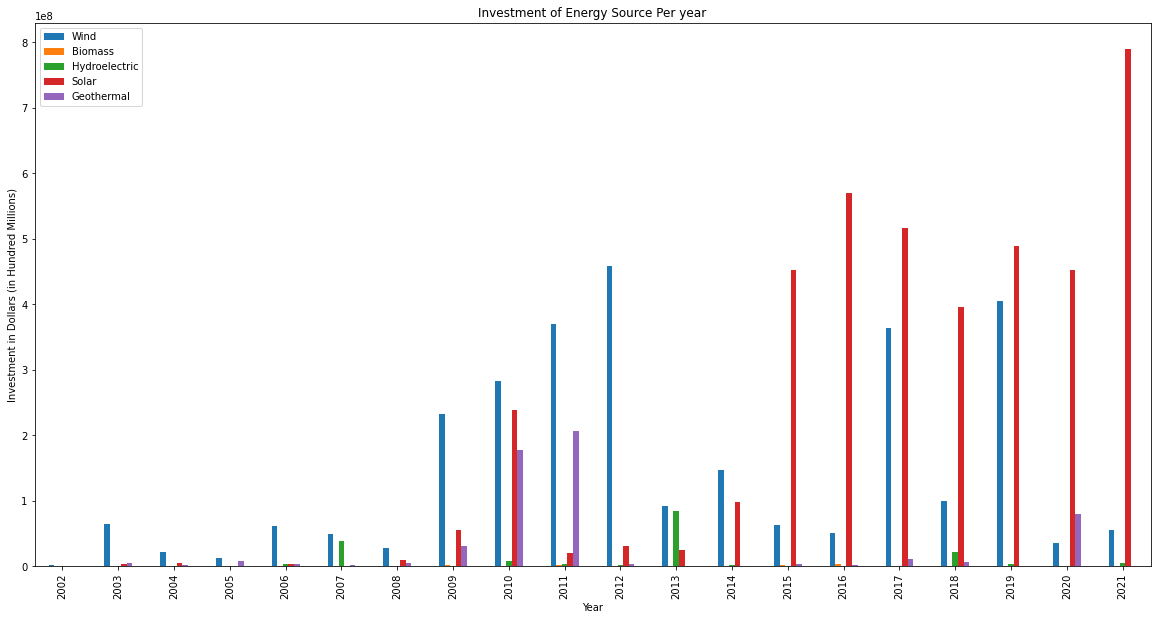

In [181]:
#Create Hbar graph showcase each years totals of Investment per Energy Source
energy_total.plot.bar(figsize =(20,10),title= 'Investment of Energy Source Per year',ylabel='Investment in Dollars (in Hundred Millions)')